In [118]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv
import os

In [119]:
load_dotenv()  

True

In [120]:
Api_key = os.getenv("OPENAI_API_KEY")

In [121]:
# model = ChatOpenAI(
#     model="gpt-4o-mini",  # or gpt-3.5-turbo if available
#     temperature=0
# )

model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key= Api_key
)


In [122]:
# create a state

class LLMState(TypedDict):
    prompt: str
    response: str
    verified: str


In [123]:
def llm_qa(state : LLMState) -> LLMState:
    prompt = state["prompt"]
    
    question = f"Answer the following question concisely: {prompt}"

    response = model.invoke(question).content

    state["response"] = response
    
    return state


In [124]:
def verify_response(state : LLMState) -> LLMState:
    response = state["response"]
    if response and len(response) > 0:
        verified = model.invoke(f"Is the following response valid clinically? {response} , justify in 10 points ..").content
        if "yes" in verified.lower():
            print("Response verified successfully.")
        state["verified"] = verified
    else:
        state["verified"] = "Response is empty. Please check the LLM output."
    return state

In [125]:
# 01. gRAPH OBJECT 
graph = StateGraph(LLMState)

# cREATE nodes 
graph.add_node("llm_qa",llm_qa)
graph.add_node("verify_response",verify_response) 

# 04.  add edges to your graph
graph.add_edge(START,"llm_qa")
graph.add_edge("llm_qa","verify_response")
graph.add_edge("verify_response",END)

workflow = graph.compile()


In [128]:
initial_state = {
    "prompt": "20 precautions to take while having atopic dermatetis?"
}

final_state = workflow.invoke(initial_state)

print(final_state)
print("\n", final_state["response"],"\n verification status:", final_state["verified"])

{'prompt': '20 precautions to take while having atopic dermatetis?', 'response': 'Here are 20 precautions to take while managing atopic dermatitis:\n\n1. **Moisturize Regularly**: Use fragrance-free moisturizers multiple times a day.\n2. **Identify Triggers**: Keep a diary to track triggers like foods, detergents, or weather.\n3. **Avoid Hot Water**: Take lukewarm showers or baths to prevent skin dryness.\n4. **Use Gentle Cleansers**: Opt for mild, soap-free cleansers.\n5. **Wear Soft Fabrics**: Choose breathable, non-irritating fabrics like cotton.\n6. **Limit Scratching**: Keep nails short and consider wearing gloves at night.\n7. **Stay Hydrated**: Drink plenty of water to maintain skin hydration.\n8. **Follow a Skincare Routine**: Stick to a consistent moisturizing and cleansing routine.\n9. **Use Humidifiers**: Add moisture to the air, especially in dry climates or during winter.\n10. **Patch Test Products**: Test new skincare products on a small area before full use.\n11. **Avoid

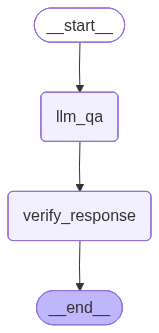

In [127]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())